In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import patches
from matplotlib.figure import Figure
from matplotlib import rcParams
from scipy import signal
    
def zplane(b,a,filename=None):
    """Plot the complex z-plane given a transfer function.
    """

    # get a figure/plot
    ax = plt.subplot(111)

    # create the unit circle
    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black', ls='dashed')
    ax.add_patch(uc)

    # The coefficients are less than 1, normalize the coeficients
    if np.max(b) > 1:
        kn = np.max(b)
        b = b/float(kn)
    else:
        kn = 1

    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
        
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)
    k = kn/float(kd)
    
    # Plot the zeros and set marker properties    
    t1 = plt.plot(z.real, z.imag, 'go', ms=10)
    plt.setp( t1, markersize=10.0, markeredgewidth=1.0,
              markeredgecolor='k', markerfacecolor='g')

    # Plot the poles and set marker properties
    t2 = plt.plot(p.real, p.imag, 'rx', ms=10)
    plt.setp( t2, markersize=12.0, markeredgewidth=3.0,
              markeredgecolor='r', markerfacecolor='r')

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set the ticks
    r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)
    ax.set_title('Zeros/Poles of Z transform')

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
    

    return z, p, k

def filterResponse(b,a):
    w,h=signal.freqz(b,a)
    fig = plt.figure()
    plt.title('Digital filter frequency response')
    ax1 = fig.add_subplot(111)
    plt.plot(w, 20 * np.log10(np.abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')
    plt.grid()
    plt.axis('tight')
    
def impulseResponse(b,a,N=0):
    if N==0:
        N=len(b)
    impulse=np.zeros(N)
    impulse[0]=1
    impulR=signal.lfilter(b,a,impulse)
    
    plt.figure()
    plt.subplot(211)
    plt.plot(impulR,'b.-',label='Impulse response')
    plt.title('Impulse and Step Response')
    plt.ylabel('Impulse')
#     plt.legend()
    plt.subplot(212)
    plt.plot(np.cumsum(impulR),'b.-',label='Step response')
    plt.ylabel('Step')
    plt.xlabel('samples')
#     plt.legend()
    plt.tight_layout()
    

In [2]:
%matplotlib inline

In [3]:
from scipy import signal
import numpy as np

class zero2min():
    def __init__(self,b,a):
        self.z,self.p,self.k=signal.tf2zpk(b,a)
        npos=abs(self.z)>1.0
        self.zOut=self.z[npos]
        self.z[npos]=1./self.z[npos]
        self.factor=np.prod(np.abs(self.zOut))
        print('number of zeros outside unit circle:',len(self.zOut))


               
    
    def minAll(self):
        ''' return the minimum phase part and all pass part of the original filter'''
        
#         if len(self.zOut)%2==1.0:
#             factor *= -1
#     #         print('****************************')

        bMin,aMin=signal.zpk2tf(self.z,self.p,self.k*self.factor)
        bAll,aAll=signal.zpk2tf(self.zOut,1./self.zOut,self.k/self.factor)

        return bMin,aMin,bAll,aAll
    
    def minMax(self):
        '''treat the original filter as a minimum part and a maxmum part. 
        Return the correction to make the maxmum filter to a minmum filter'''
        bb,aa=signal.zpk2tf(self.zOut,np.zeros(len(self.zOut)),1)

        br=bb/bb[-1]
        ar=np.zeros_like(br)
        ar[0]=1   
        ar[1:]=bb[0:-1][::-1]/bb[-1]
        
        return br,ar

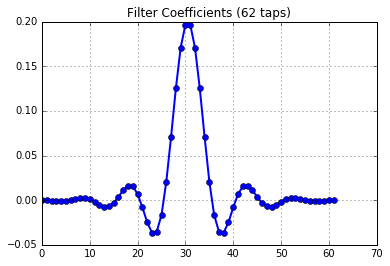

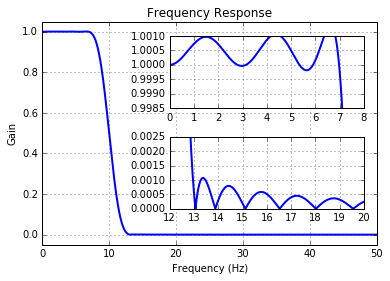

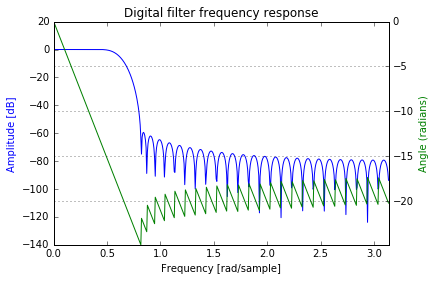

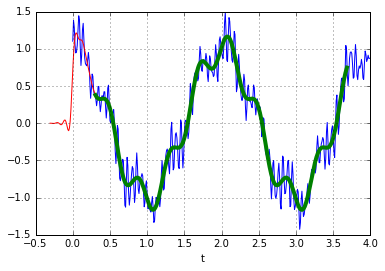

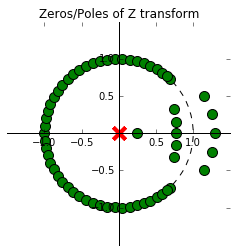

In [4]:
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
%matplotlib inline

#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 100.0
nsamples = 400
t = arange(nsamples) / sample_rate
x = cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
        0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
            0.1*sin(2*pi*23.45*t+.8)


#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 6 Hz transition width.
width = 6.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 10.0


# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# taps=51

# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, x)

#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------

figure(1)
plot(taps, 'bo-', linewidth=2)
title('Filter Coefficients (%d taps)' % N)
grid(True)

#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------

figure(2)
clf()
w, h = freqz(taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(0,8.0)
ylim(0.9985, 1.001)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)



b=taps
a=np.zeros(len(b))
a[0]=1
filterResponse(b,a)

#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

figure(4)
# Plot the original signal.
plot(t, x)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, filtered_x, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, filtered_x[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

figure(5)

z,p,k=zplane(b,a)


show()

number of zeros outside unit circle: 32
number of zeros in original filter: 61 61 # number of zeros in minPhase filter: 61 61
-----------------------------------------------------------------
############## all pass part of the filter ######################


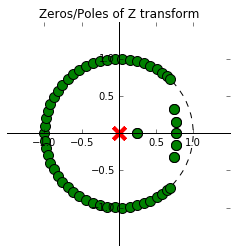

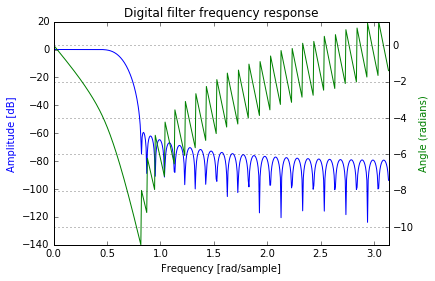

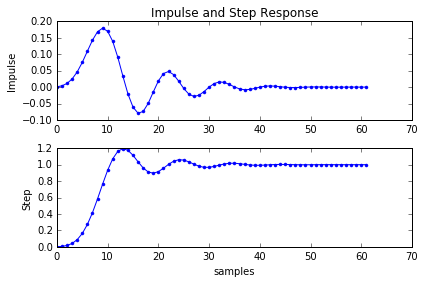

In [5]:
obj=zero2min(b,a)
b1,a1,b2,a2=obj.minAll()

print('number of zeros in original filter:',len(b)-1,len(a)-1,'# number of zeros in minPhase filter:',len(b1)-1,len(a1)-1)
print('-----------------------------------------------------------------')

print('############## all pass part of the filter ######################')
zplane(b1,a1)
filterResponse(b1,a1)
impulseResponse(b1,a1)


############## all pass part of the filter ######################


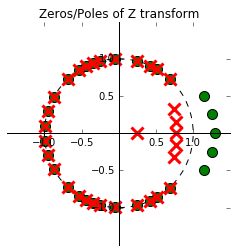

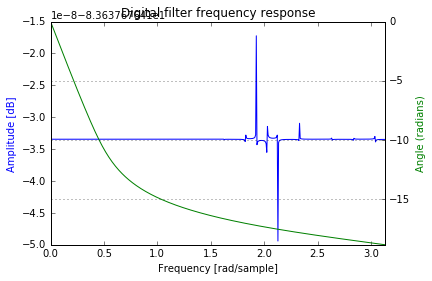

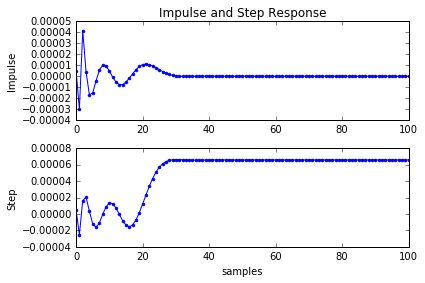

In [6]:
print('############## all pass part of the filter ######################')

zplane(b2,a2)
filterResponse(b2,a2)
impulseResponse(b2,a2,101)

# Two methods to convert a zero phase filter to a minimum phase filter

Method 1 is to decompose the zero phase filter response to a minimum phase filter and a all pass filter: H(z)=Hmin(z)*Hap(z)
read 
Discrete-time signal processing, Third edition
by Alan V. Oppenheim, Ronald W. Schafer
Section 5.6 Minimum-phase system,  P311-317

Note: Method 1 could accumulate a lot of rounding errors in calculating the minimum phase filter. And somehow this method could be unstable. So it is a good way to understand this decomposition of zero phase filter, but not a good practical way.

Also read:
http://dspguru.com/dsp/howtos/how-to-design-minimum-phase-fir-filters

https://www.dsprelated.com/freebooks/filters/Minimum_Phase_Filters.html

Method 2 is to decompose the zero phase filter to a minimum phase part and a maximum phase part. H(z)=Hmin(z)*Hmax(z) Then correct the maximum phase part into minimum phase via post-filtration of the time-reversed signal.
See
FIR filter effects and nucleation phases, by Frank Scherbaum and Marie-Paule Bouin, GJI, 1997

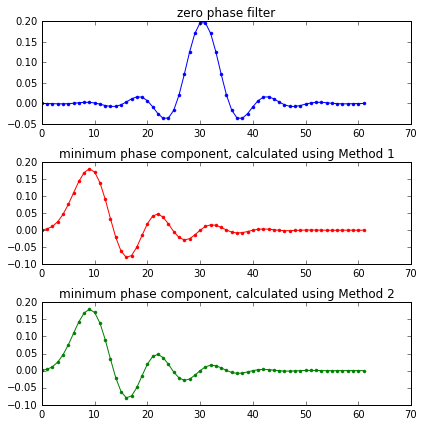

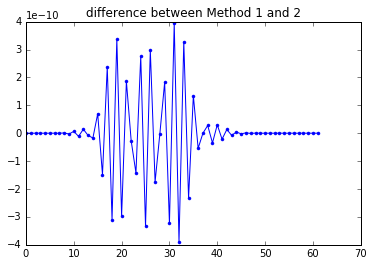

In [7]:
b3,a3=obj.minMax()

impulse=np.zeros(len(taps))
# impulse=taps
impulse[0]=1
impulX=signal.lfilter(b,a,impulse)
impulX1=signal.lfilter(b1,a1,impulse)
impulX2=signal.lfilter(b3,a3,impulX[::-1])[::-1]
fig=plt.figure(figsize=[6,6])
plt.subplot(311)
plt.plot(impulX,'b.-')
plt.title('zero phase filter')
plt.subplot(312)
plt.plot(impulX1,'r.-')
plt.title('minimum phase component, calculated using Method 1')
plt.subplot(313)
plt.plot(impulX2,'g.-')
plt.title('minimum phase component, calculated using Method 2')
plt.tight_layout()

plt.figure()
plt.plot(impulX1-impulX2,'b.-')
plt.title('difference between Method 1 and 2')

# A simple example

In [8]:
import cmath

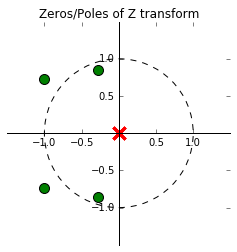

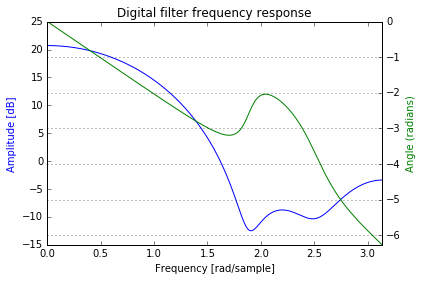

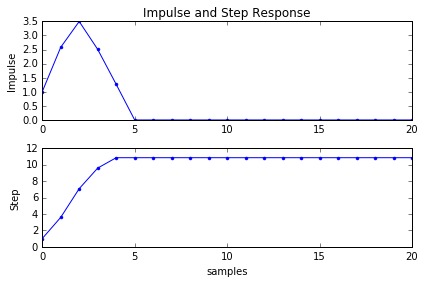

In [9]:
z=np.empty(4,dtype='complex128')
z[0]=cmath.rect(0.9,0.6*np.pi)
z[1]=cmath.rect(0.9,-0.6*np.pi)
z[2]=cmath.rect(1.25,0.8*np.pi)
z[3]=cmath.rect(1.25,-0.8*np.pi)
p=np.zeros(len(z))
k=1.0

b,a=signal.zpk2tf(z,p,k)

zplane(b,a)
filterResponse(b,a)
impulseResponse(b,a,21)




number of zeros outside unit circle: 2
############### for the minimum phase part #################


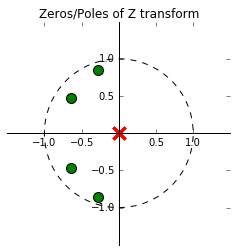

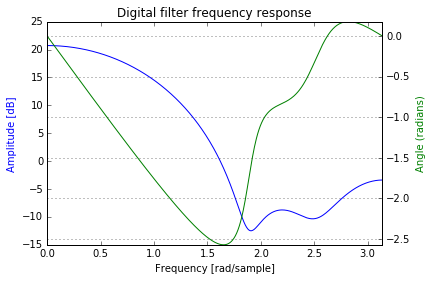

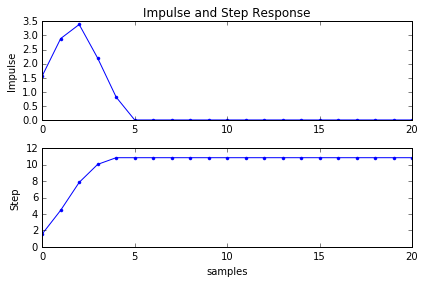

In [10]:
obj2=zero2min(b,a)
b1,a1,b2,a2=obj2.minAll()

print('############### for the minimum phase part #################')
zplane(b1,a1)
filterResponse(b1,a1)
impulseResponse(b1,a1,21)

############### for the all-pass part #################


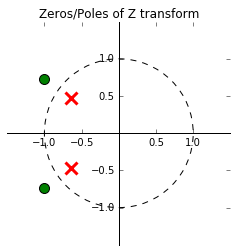

[ 0.64        1.29442719  1.        ] [ 1.          1.29442719  0.64      ]


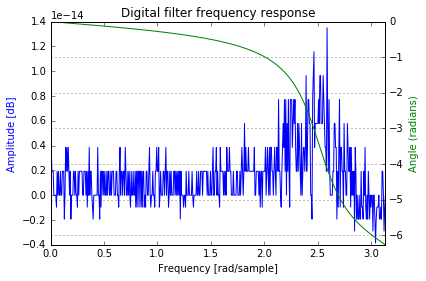

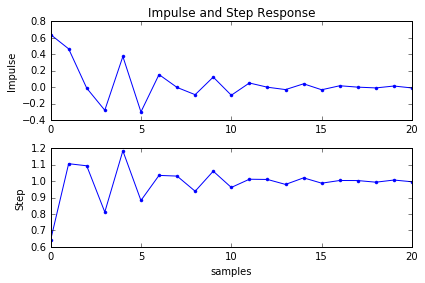

In [11]:
print('############### for the all-pass part #################')

z,p,k=zplane(b2,a2)
filterResponse(b2,a2)
impulseResponse(b2,a2,21)
print(b2,a2)

# minimum phase and all pass filter components calculated by hand

############### for the minimum phase part #################


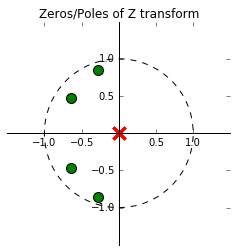

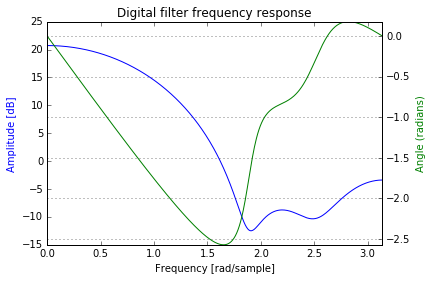

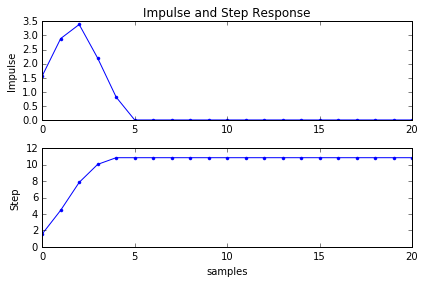

In [12]:
print('############### for the minimum phase part #################')

z=np.empty(4,dtype='complex128')
z[0]=cmath.rect(0.9,0.6*np.pi)
z[1]=cmath.rect(0.9,-0.6*np.pi)
z[2]=cmath.rect(0.8,-0.8*np.pi)
z[3]=cmath.rect(0.8,0.8*np.pi)
p=np.zeros(len(z))
k=1.25*1.25


b,a=signal.zpk2tf(z,p,k)

z,p,k=zplane(b,a)
filterResponse(b,a)
impulseResponse(b,a,21)


############### for the all pass part #################


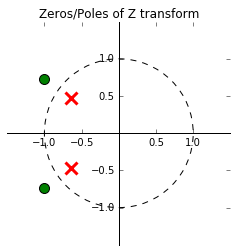

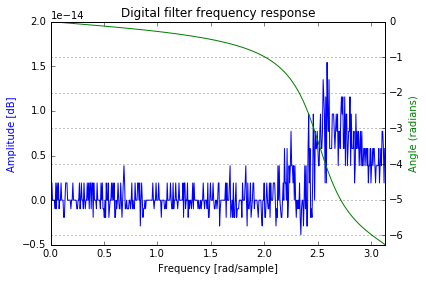

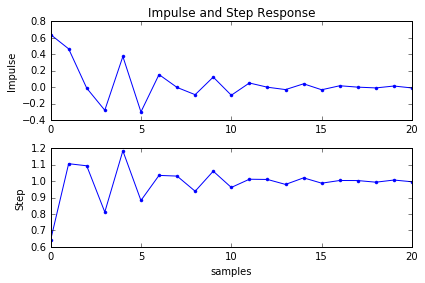

In [13]:
print('############### for the all pass part #################')

z=np.empty(2,dtype='complex128')
z[0]=cmath.rect(1/0.8,0.8*np.pi)
z[1]=cmath.rect(1/0.8,-0.8*np.pi)
p=np.empty_like(z)
p[0]=cmath.rect(0.8,0.8*np.pi)
p[1]=cmath.rect(0.8,-0.8*np.pi)
k=0.8*0.8

b,a=signal.zpk2tf(z,p,k)

z,p,k=zplane(b,a)
filterResponse(b,a)
impulseResponse(b,a,21)